In [4]:
import numpy as np
import matplotlib.pyplot as plt
from math import * 


def TDMA(a, b, c, d):
    n = len(b)
    p, q = np.zeros(n), np.zeros(n)
    c = c + [0]
    p[0] = c[0] / b[0]
    q[0] = d[0] / b[0]
    for i in range(1, n):
        p[i] = c[i] / (b[i] - (a[i - 1] * p[i - 1]))
        q[i] = (d[i] - (a[i - 1] * q[i - 1])) / (b[i] - (a[i - 1]*p[i - 1]))

    x = np.zeros(n)
    m = n - 1

    x[m] = q[-1]
    for i in range(n - 2, -1, -1):
        x[i] = q[i] - (x[i + 1] * p[i])
    return x

#Условие задачи двумерного уравнения теплопроводности
lm = 10**(-4)
u_an = lambda t, x, y: cos(pi*x)*sin(5*pi*y)*exp(-50*(pi**2)*lm*t)
u0x = lambda t, y: sin(5*pi*y)*exp(-50*(pi**2)*lm*t)
u1x = lambda t, y: -sin(5*pi*y)*exp(-50*(pi**2)*lm*t)

u = np.zeros([])
v = np.zeros([])

def calc(N, Nx, Ny):
    global v
    global u
    eps = 10**(-4)
    tt = np.linspace(0, 1, N+1)
    xx = np.linspace(0, 1, Nx+1)
    yy = np.linspace(0, 1, Ny+1)

    tau = np.diff(tt)[0]
    hx = np.diff(xx)[0]
    hy = np.diff(yy)[0]
    
    u = np.zeros([N+1, Nx+1, Ny+1])
    v = np.zeros([N+1, Nx+1, Ny+1])

    for i in range(Nx + 1):
        for j in range(Ny + 1):
            u[0, i, j] = cos(pi*xx[i]) * sin(5*pi*yy[j])

    u[:, 0, :] = [[u0x(t, y) for y in yy] for t in tt]
    u[:, Nx, :] = [[u1x(t, y) for y in yy] for t in tt]

    a = (-50*lm/(hx**2)) - (2*lm/(hy**2)) - (1/tau)
    b = lm/(hy**2)
    c = 25*lm/(hx**2)

    a2 = [0] + [c for m in range(1, Nx)]
    
    a1 = [0] + [b for m in range(1, Nx)]

    a0 = [1] + [a for l in range(1, Nx)] + [1]

    a_1 = [b for m in range(1, Nx)] + [0]
    a_2 = [c for m in range(1, Nx)] + [0]
    
    A0 = np.diag(a0)
    A1 = np.diag(a1, k=1)
    A_1 = np.diag(a_1, k=-1)
    A2 = np.diag(a2, k=1)
    A_2 = np.diag(a_2, k=-1)
    A11 = A0 + A1 + A_1 #матрица для 1 прогонки
    A22 = A0 + A2 + A_2 #матрица для 2 прогонки
    
    for n in range(N):
        if n % 2 == 0:
            for j in range(1, Ny):
                d = [u0x(tt[n+1], yy[j])] + [-(u[n, i, j]/tau)-(b*u[n+1, i, j-1])-(b*u[n, i, j+1]) for i in range(1, Nx)] + [u1x(tt[n+1], yy[j])]
                u[n+1, :, j] = TDMA(a_2, a0, a2, d) 
        else:
            for i in range(1, Nx):
                d = [0] + [-(u[n, i, j]/tau)-(c*u[n+1, i-1, j])-(c*u[n, i+1, j]) for j in range(1, Ny)] + [0]
                u[n+1, i, :] = TDMA(a_1, a0, a1, d)

    d = 0
    for l in range(Nx+1):
        for m in range(Ny+1):
            d = max(d, abs(u_an(tt[-1], xx[l], yy[m]) - u[-1, l, m]))
            v[-1, l, m] = u_an(tt[-1], xx[l], yy[m])

    return d

In [5]:
res = []
res.append(calc(100, 10, 10))
res.append(calc(200, 20, 20))
res.append(calc(400, 30, 30))
res.append(calc(800, 40, 40))
res.append(calc(1600, 50, 50))

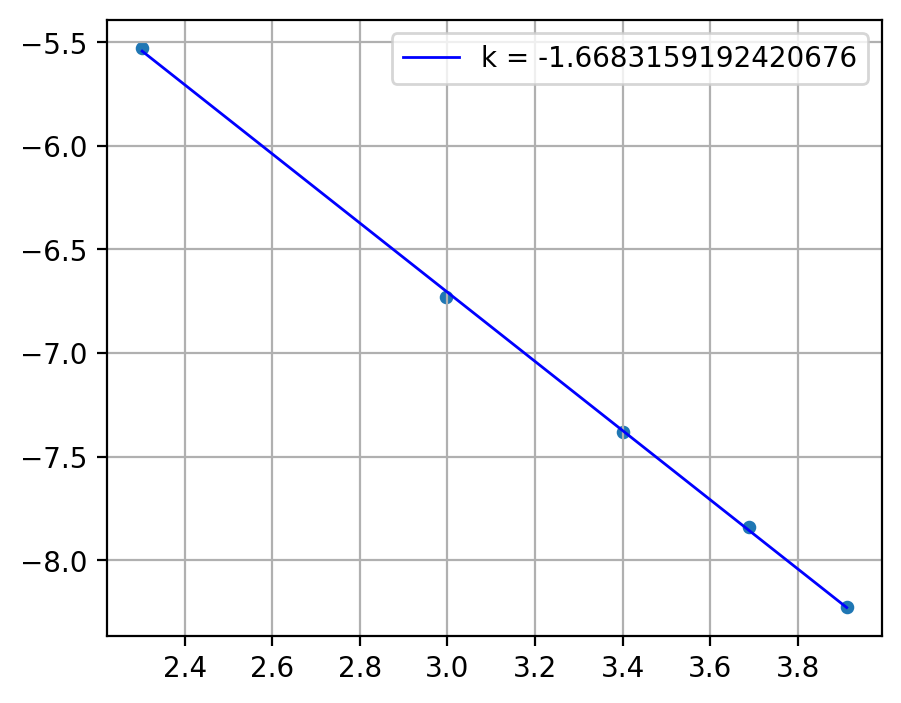

In [6]:
h = np.array([10, 20, 30, 40, 50])
fig, ax = plt.subplots(figsize=(5, 4), dpi=200)

#Метод наименьших квадратов
p1 = np.polyfit(np.log(h),np.log(np.array(res)), 1)
P01 = np.polyval(p1,np.log(h))

plt.grid()

plt.plot(np.log(h), P01, "blue", label = f'k = {p1[0]}', linewidth = 1)
plt.scatter(np.log(h), np.log(np.array(res)), s=15)
plt.legend()
plt.show()